<a href="https://colab.research.google.com/github/Aipakazuma/meetup037/blob/master/004_Keras_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Function

Kerasのレイヤーを関数化することでできることを試す

## やること

* CNNモデルの構築
* 中間層の出力結果を確認する

In [1]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.utils import np_utils
from keras.callbacks import TensorBoard


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

Using TensorFlow backend.


## Tensorbaord準備

In [2]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
updated 1 package in 2.862s


In [0]:
!rm -rf ./logs/
!mkdir ./logs/

In [0]:
log_dir = './logs/'

In [0]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(log_dir)
)

In [0]:
# 負荷かなにかでまれに落ちるので再実行してください
get_ipython().system_raw('lt --port 6006 > url.txt 2>&1 &')

In [7]:
!cat url.txt

your url is: https://pretty-lizard-19.localtunnel.me


## データの読み込み

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## 前処理

In [0]:
# 画像を0-1の範囲で正規化
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 正解ラベルをOne-Hot表現に変換
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

## CNNモデル構築

In [0]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

## モデル学習

In [11]:
epochs = 10
batch_size = 128

try:
  
    # 実行するたびにディレクトリを作成するようにする.
    a = datetime.now()
    logs_name = a.strftime('%Y%m%d_%H%M%S')
    write_log_dir = '{}{}/'.format(log_dir, logs_name)
    tensorboard = TensorBoard(log_dir=write_log_dir,
                          histogram_freq=False,  # histogramの出力. 各レイヤーの値の分布を表示(3次元) -> これすごく重い
                          batch_size=batch_size,  # batch_sizeの指定
                          write_grads=True,  # 各レイヤーの値の分布の表示(2次元)
                          write_images=True,  # 各レイヤーの重み、バイアスを画像で表示
                          embeddings_freq=False)
    print('書き込むディレクトリ名: {}'.format(write_log_dir))
    
    # 学習
    callbacks = [tensorboard]
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                     callbacks=callbacks, validation_data=(X_test, y_test))
except KeyboardInterrupt:
    tensorboard.writer.close()

書き込むディレクトリ名: ./logs/20181215_025303/
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 173us/step - loss: 1.6087 - acc: 0.4214 - val_loss: 1.3451 - val_acc: 0.5227
Epoch 2/10
50000/50000 [==============================] - 7s 144us/step - loss: 1.2534 - acc: 0.5595 - val_loss: 1.2197 - val_acc: 0.5625
Epoch 3/10
50000/50000 [==============================] - 7s 145us/step - loss: 1.1244 - acc: 0.6078 - val_loss: 1.1238 - val_acc: 0.6075
Epoch 4/10
50000/50000 [==============================] - 7s 145us/step - loss: 1.0473 - acc: 0.6357 - val_loss: 1.0598 - val_acc: 0.6342
Epoch 5/10
50000/50000 [==============================] - 7s 147us/step - loss: 0.9874 - acc: 0.6554 - val_loss: 0.9963 - val_acc: 0.6558
Epoch 6/10
50000/50000 [==============================] - 7s 144us/step - loss: 0.9416 - acc: 0.6732 - val_loss: 1.0302 - val_acc: 0.6499
Epoch 7/10
50000/50000 [==============================] - 7s 145us/step - loss: 0.902

## 中間層の出力を確認する

In [65]:
X_test[1].shape

(32, 32, 3)

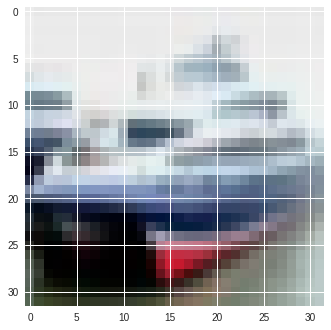

In [66]:
plt.imshow(X_test[1])

In [0]:
# こういうことができる
from keras import backend as K


# convのレイヤーのみ確認する関数を作る
t_get_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                                           [model.layers[0].output])
layer_output1 = t_get_layer_output([[X_test[1]], 0])[0]


# conv + activation
t_get_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                                           [model.layers[1].output])
layer_output2 = t_get_layer_output([[X_test[1]], 0])[0]

In [91]:
layer_output1.shape, layer_output2.shape

((1, 30, 30, 32), (1, 30, 30, 32))

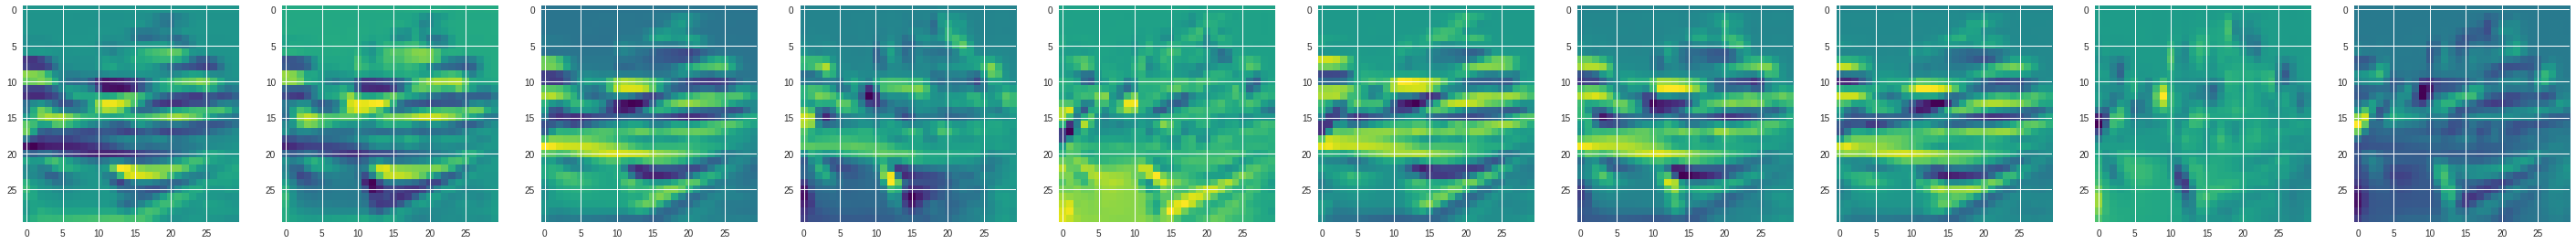

In [93]:
_, axes = plt.subplots(figsize=(50, 10), ncols=10)
for idx, ax in enumerate(axes):
    ax.imshow(layer_output1[0, :, :, idx], cmap='viridis')

plt.show()

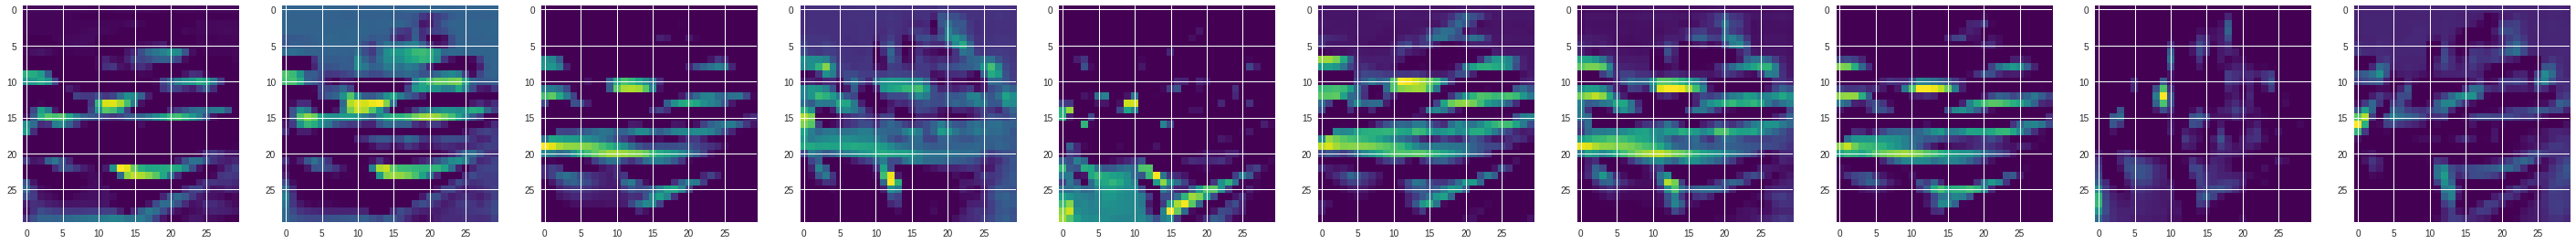

In [94]:
_, axes = plt.subplots(figsize=(50, 10), ncols=10)
for idx, ax in enumerate(axes):
    ax.imshow(layer_output2[0, :, :, idx], cmap='viridis')

plt.show()

何が便利なのか

* デバッグ
* 中間層だけで結果を確認したい

とかで便利

In [0]:
from keras.preprocessing import image as keras_image


img_tensor = keras_image.img_to_array(X_test[0])
img_tensor = np.expand_dims(img_tensor, axis=0)

In [13]:
img_tensor.shape

(1, 32, 32, 3)

In [0]:
# 各レイヤー層の出力を確認したい場合は新しいモデルを作ったほうが便利
from keras.models import Model
import re


layer_outputs = [layer.output for layer in model.layers[:8] if re.match(r'.*(pool|conv)', layer.name)]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activations = activation_model.predict(img_tensor)

In [40]:
len(activations)

4

In [41]:
activations[0].shape

(1, 30, 30, 32)

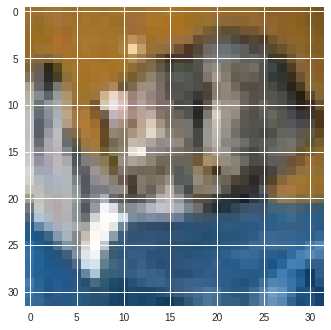

In [42]:
plt.imshow(X_test[0])

In [43]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

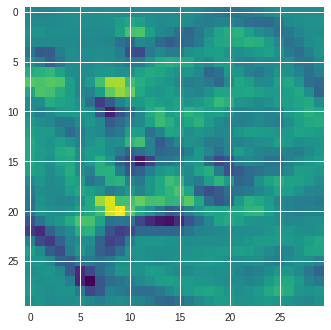

In [44]:
plt.imshow(activations[0][0, :, :, 0], cmap='viridis')
plt.show()

Keras作者の本からパクってきたコード

In [0]:
import keras


# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers:
    # convとpoolingのみ
    if not re.match(r'.*(pool|conv)', layer.name):
        continue

    layer_names.append(layer.name)

images_per_row = 16

In [46]:
layer_names

['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


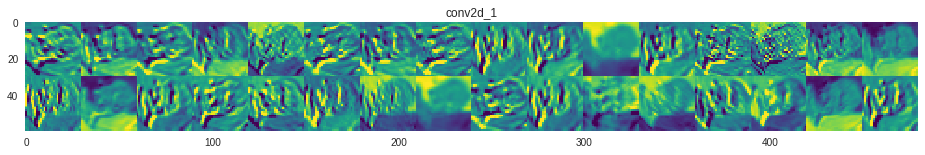

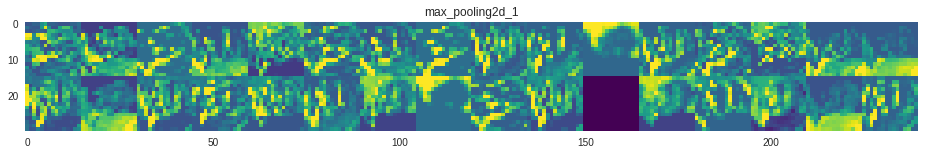

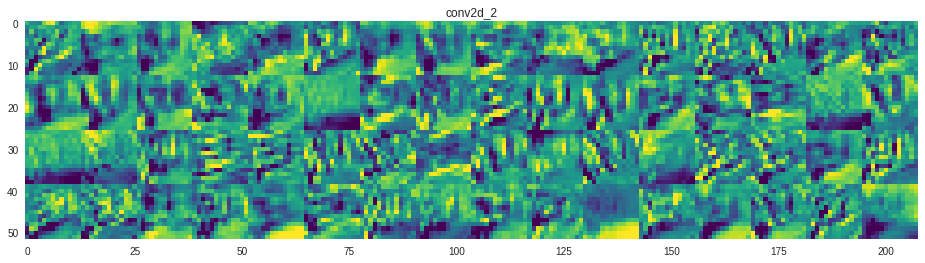

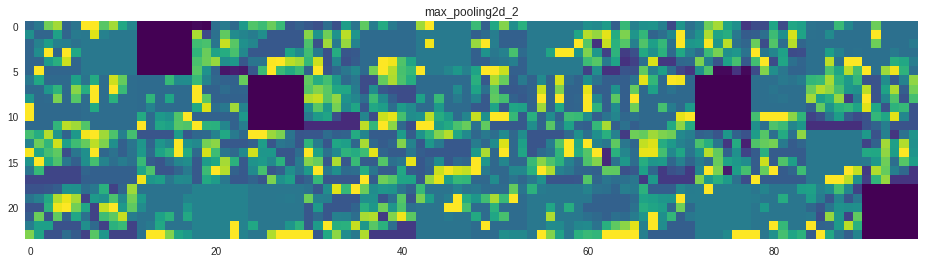

In [47]:
# Now let's display our feature maps
for idx, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()